In [1]:
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, LSTM, Flatten, GRU
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
# fix random seed for reproducibility
np.random.seed(7)
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import pandas as pd
import os
from keras.utils import to_categorical
from collections import OrderedDict
from keras import backend as K
from keras.models import Model

Using TensorFlow backend.


In [2]:
from platform import python_version
print(python_version())

3.6.6


### Exp of classifing movie genres based on their events.


In [3]:
movies = pd.read_csv('../../data/metadata_events_table.tsv', sep = '\t')

In [4]:
movies.Genre_code.value_counts()

2    2419
1    1643
4     679
0     485
3     144
Name: Genre_code, dtype: int64

In [5]:
# df0 = movies[movies['Genre_code'] == 0].sample(500, replace = True)
# df1 = movies[movies['Genre_code'] == 1].sample(500)
# df2 = movies[movies['Genre_code'] == 2].sample(500)
# df3 = movies[movies['Genre_code'] == 3].sample(500)
# df4 = movies[movies['Genre_code'] == 4].sample(500)

In [6]:
# movies = pd.concat([df0, df1, df2, df3, df4])

In [7]:
len(movies)

5370

In [8]:
movies = movies.sort_values('Genre_code').reset_index()

In [9]:
{0: 'Action', 1: 'Comedy', 2: 'Drama', 3: 'Romance Film', 4: 'Thriller'}

{0: 'Action', 1: 'Comedy', 2: 'Drama', 3: 'Romance Film', 4: 'Thriller'}

In [10]:
#starting and ending index for each group for plotting
action_s = min(movies[movies['Genre_code'] == 0].index.tolist())
action_e = max(movies[movies['Genre_code'] == 0].index.tolist())
comedy_s = min(movies[movies['Genre_code'] == 1].index.tolist())
comedy_e = max(movies[movies['Genre_code'] == 1].index.tolist())
drama_s = min(movies[movies['Genre_code'] == 2].index.tolist())
drama_e = max(movies[movies['Genre_code'] == 2].index.tolist())
romance_s = min(movies[movies['Genre_code'] == 3].index.tolist())
romance_e = max(movies[movies['Genre_code'] == 3].index.tolist())
thriller_s = min(movies[movies['Genre_code'] == 4].index.tolist())
thriller_e = max(movies[movies['Genre_code'] == 4].index.tolist())


In [11]:
for item in movies[movies['Genre_code'] == 4].Events.head(20).tolist():
    print(item)
    print()

['judgment-33', 'discipline', 'say-37.7', 'avoid-52', 'future_having-13.3', 'judgment-33', 'send-11.1-1', 'reflexive_appearance-48.1.2', 'contiguous_location-47.8-1', 'urge-58.1', 'masquerade-29.6', 'reflexive_appearance-48.1.2', 'calibratable_cos-45.6-1', 'poison-42.2', 'subjugate-42.3', 'subjugate-42.3', 'establish-55.5-1', 'escape-51.1']

['send-11.1-1', 'investigate-35.4', 'meet-36.3-1', 'other_cos-45.4', 'consider-29.9-1-1', 'conjecture-29.5-1', 'bring-11.3-1', 'other_cos-45.4', 'neglect-75-1-1', 'lodge-46', 'resign-10.11', 'conspire-71', 'pretend', 'escape-51.1', 'say-37.7-1', 'peer-30.3', 'leave-51.2', 'say-37.7', 'peer-30.3', 'rummage-35.5', 'amuse-31.1', 'forbid-67-1', 'conjecture-29.5-2', 'transfer_mesg-37.1.1', 'inquire-37.1.2', 'meet-36.3-1', 'meet-36.3-1', 'neglect-75-2', 'put-9.1-2', 'transfer_mesg-37.1.1-1-1', 'own-100', 'calibratable_cos-45.6-1', 'performance-26.7-1', 'escape-51.1', 'get-13.5.1', 'get-13.5.1']

['involve-107', 'admit-65', 'admit-65', 'performance-26.7-1

### Encode as one-hot vectors

In [12]:
t = Tokenizer()

In [13]:
events = []
for e in movies.Events.tolist():
    events.append([item.split('-')[0] for item in eval(e)])

In [14]:
# Size of data
print(len(events))

5370


In [15]:
t.fit_on_texts(events)

In [16]:
t.word_index

{'amuse': 1,
 'get': 2,
 'escape': 3,
 'discover': 4,
 'own': 5,
 'meander': 6,
 'transfer_mesg': 7,
 'become': 8,
 'conjecture': 9,
 'say': 10,
 'other_cos': 11,
 'correspond': 12,
 'force': 13,
 'obtain': 14,
 'appear': 15,
 'convert': 16,
 'run': 17,
 'meet': 18,
 'give': 19,
 'characterize': 20,
 'future_having': 21,
 'admire': 22,
 'begin': 23,
 'contiguous_location': 24,
 'steal': 25,
 'subjugate': 26,
 'reflexive_appearance': 27,
 'seem': 28,
 'send': 29,
 'sight': 30,
 'judgment': 31,
 'admit': 32,
 'remove': 33,
 'marvel': 34,
 'exist': 35,
 'tell': 36,
 'calibratable_cos': 37,
 'crane': 38,
 'appoint': 39,
 'urge': 40,
 'fit': 41,
 'contribute': 42,
 'put': 43,
 'confront': 44,
 'lodge': 45,
 'refuse': 46,
 'involve': 47,
 'wish': 48,
 'try': 49,
 'consider': 50,
 'see': 51,
 'help': 52,
 'want': 53,
 'dub': 54,
 'resign': 55,
 'sustain': 56,
 'disappearance': 57,
 'throw': 58,
 'stop': 59,
 'order': 60,
 'learn': 61,
 'knead': 62,
 'sound_emission': 63,
 'peer': 64,
 'manner

In [17]:
embedding_input_dim = max(t.word_index.values())+1

In [18]:
embedding_input_dim

976

In [19]:
msk = np.random.rand(len(movies)) < 0.8
train = []
for e in movies[msk]['Events'].tolist():
    train.append([item.split('-')[0] for item in eval(e)])
test = []
for e in movies[~msk]['Events'].tolist():
    test.append([item.split('-')[0] for item in eval(e)])


In [20]:
x_train = t.texts_to_sequences(train)
x_train = pad_sequences(x_train, maxlen=50)
# x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

In [22]:
x_train.shape

(4307, 50)

In [23]:
events_trans = t.texts_to_sequences(events)
events_trans = pad_sequences(events_trans, maxlen=50)
# events_trans = np.reshape(events_trans, (events_trans.shape[0], events_trans.shape[1], 1))

In [24]:
x_test = t.texts_to_sequences(test)
x_test = pad_sequences(x_test, maxlen=20)
# x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [25]:
y_train = to_categorical(movies[msk]['Genre_code'].tolist())
y_test = to_categorical(movies[~msk]['Genre_code'].tolist())

### Simple LSTM 

In [26]:
# create the model
embedding_vector_length = 20
model = Sequential()
model.add(Embedding(embedding_input_dim, embedding_vector_length))
model.add( LSTM(20))
model.add(Dense(5, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())
model.fit(x_train, y_train, epochs=3, batch_size=32)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 20)          19520     
_________________________________________________________________
lstm_1 (LSTM)                (None, 20)                3280      
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 105       
Total params: 22,905
Trainable params: 22,905
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/3
4307/4307 [==============================] - 3s 794us/step - loss: 1.3604 - acc: 0.4456
Epoch 2/3
4307/4307 [==============================] - 3s 678us/step - loss: 1.2851 - acc: 0.4500
Epoch 3/3
4307/4307 [==============================] - 3s 684us/step - loss: 1.2434 - acc: 0.4681


In [27]:
# Final evaluation of the model
scores = model.evaluate(x_test,
                        y_test)
print("Accuracy: %.2f%%" % (scores[1]*100))

1063/1063 [==============================] - 0s 138us/step
Accuracy: 47.79%


### Obtain embeddings

In [28]:
# #Get indimediate layer output using tensorflow backend
# get_lstm_output = K.function([model.layers[0].input], [model.layers[1].output])
# output = get_lstm_output([x_train])

In [29]:
#Alternative way, same result
intermediate_layer_model = Model(inputs=model.input,
                                 outputs=model.get_layer('lstm_1').output)
# intermediate_output = intermediate_layer_model.predict(x_train[0][0:])

In [30]:
vecs = []
for i in range(len(events)):
    output = intermediate_layer_model.predict(events_trans[i])
#     print(output.shape)
#     print(output[0])
#     break
    vecs.append(output[-1])


### Cluster embeddings

In [31]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA


In [32]:
embedded = TSNE(n_components=2).fit_transform(vecs)
embedded.shape

(5370, 2)

In [33]:
{0: 'Action', 1: 'Comedy', 2: 'Drama', 3: 'Romance Film', 4: 'Thriller'}

{0: 'Action', 1: 'Comedy', 2: 'Drama', 3: 'Romance Film', 4: 'Thriller'}

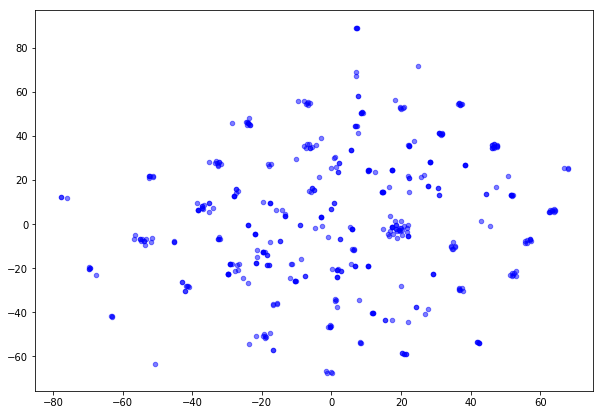

In [34]:
plt.figure(figsize = (10,7))
plt.scatter(embedded[action_s:action_e,0], embedded[action_s:action_e,1], s = 20,color='blue', label = 'Action', alpha = 0.5)
# plt.scatter(embedded[comedy_s:comedy_e,0], embedded[comedy_s:comedy_e,1], s =20,color='yellow', label = 'Comedy', alpha = 0.5)
# plt.scatter(embedded[drama_s:drama_e,0], embedded[drama_s:drama_e,1], s = 20,color='red', label = 'Drama', alpha = 0.5)
# plt.scatter(embedded[romance_s:romance_e,0], embedded[romance_s:romance_e,1], s = 20,color='green', label = 'Romance', alpha = 0.5)
# plt.scatter(embedded[thriller_s:thriller_e,0], embedded[thriller_s:thriller_e,1], s = 20,color='grey', label = 'Thriller', alpha = 0.5)
# # plt.legend()

In [35]:
pca = PCA(n_components=2)
embedded = pca.fit_transform(vecs)

In [36]:
embedded.shape

(5370, 2)

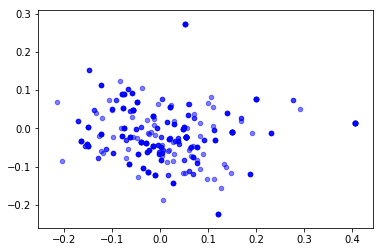

In [37]:
# plt.figure(figsize = (10,7))
plt.scatter(embedded[action_s:action_e,0], embedded[action_s:action_e,1], s = 20,color='blue', label = 'Action', alpha = 0.5)

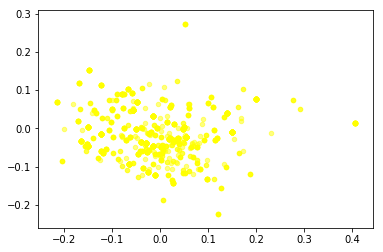

In [38]:
plt.scatter(embedded[comedy_s:comedy_e,0], embedded[comedy_s:comedy_e,1], s =20,color='yellow', label = 'Comedy', alpha = 0.5)

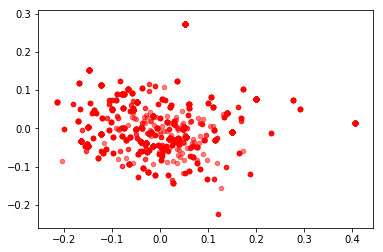

In [39]:
plt.scatter(embedded[drama_s:drama_e,0], embedded[drama_s:drama_e,1], s = 20,color='red', label = 'Drama', alpha = 0.5)

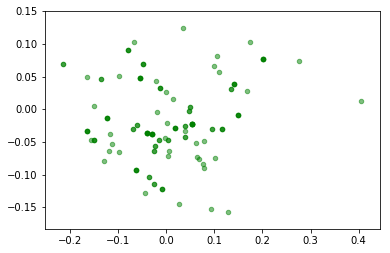

In [40]:
plt.scatter(embedded[romance_s:romance_e,0], embedded[romance_s:romance_e,1], s = 20,color='green', label = 'Romance', alpha = 0.5)

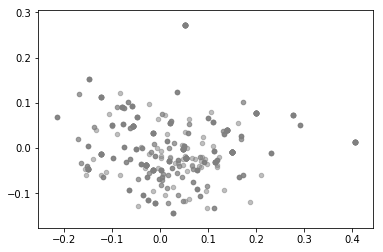

In [41]:
plt.scatter(embedded[thriller_s:thriller_e,0], embedded[thriller_s:thriller_e,1], s = 20,color='grey', label = 'Thriller', alpha = 0.5)
# plt.legend()

In [42]:
print(pca.explained_variance_ratio_)  

[0.64486534 0.2828508 ]


In [43]:
print(pca.singular_values_)  

[7.92524046 5.24875902]


### Baselines

In [46]:
# create the model
embedding_vector_length = 20
model = Sequential()
model.add(Embedding(embedding_input_dim, embedding_vector_length,input_length=50))
model.add(Flatten())
model.add(Dense(5, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())
model.fit(x_train, y_train, epochs=3, batch_size=32)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 50, 20)            19520     
_________________________________________________________________
flatten_2 (Flatten)          (None, 1000)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 5)                 5005      
Total params: 24,525
Trainable params: 24,525
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/3
4307/4307 [==============================] - 0s 81us/step - loss: 1.3394 - acc: 0.4451
Epoch 2/3
4307/4307 [==============================] - 0s 29us/step - loss: 1.2821 - acc: 0.4504
Epoch 3/3
4307/4307 [==============================] - 0s 28us/step - loss: 1.2385 - acc: 0.4639


In [53]:
# create the model
model = Sequential()
model.add(Dense(100, input_dim = 50, activation='relu'))
model.add(Dense(5, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())
model.fit(x_train, y_train, epochs=3, batch_size=32)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_13 (Dense)             (None, 100)               5100      
_________________________________________________________________
dense_14 (Dense)             (None, 5)                 505       
Total params: 5,605
Trainable params: 5,605
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/3
4307/4307 [==============================] - 0s 84us/step - loss: 8.3314 - acc: 0.3947
Epoch 2/3
4307/4307 [==============================] - 0s 23us/step - loss: 7.0740 - acc: 0.4068
Epoch 3/3
4307/4307 [==============================] - 0s 23us/step - loss: 6.4949 - acc: 0.4019
